In [95]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.utils
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

In [96]:
## import des données 
df = pd.read_csv("/data/notebook_files/oil_wells_data.csv")

## On effectue ensuite la preparation des données telle que décrite dans le premier rapport

In [97]:
#premier observations des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26999 entries, 0 to 26998
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   26999 non-null  object 
 1   P-PDG       26999 non-null  float64
 2   P-TPT       26999 non-null  float64
 3   T-TPT       26999 non-null  float64
 4   P-MON-CKP   26999 non-null  float64
 5   T-JUS-CKP   26999 non-null  float64
 6   P-JUS-CKGL  0 non-null      float64
 7   T-JUS-CKGL  0 non-null      float64
 8   QGL         0 non-null      float64
 9   class       26999 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 2.1+ MB


In [98]:
df.head()

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
0,2018-05-17 22:56:06.000000,27897490.0,19824230.0,125.6859,4059666.0,97.55283,NaN,NaN,NaN,0
1,2018-05-17 22:56:07.000000,27897450.0,19824230.0,125.6859,4059666.0,97.55283,NaN,NaN,NaN,0
2,2018-05-17 22:56:08.000000,27897360.0,19824230.0,125.6859,4059666.0,97.55283,NaN,NaN,NaN,0
3,2018-05-17 22:56:09.000000,27897430.0,19824230.0,125.6859,4059666.0,97.55282,NaN,NaN,NaN,0
4,2018-05-17 22:56:10.000000,27897500.0,19824230.0,125.6859,4059666.0,97.55282,NaN,NaN,NaN,0


On remarque que 3 colonnes sont vides, on les supprime donc. On enlève également le timestemp car les données sont déjà dans le bon ordre chronologique, l'information du temps est donc conservée.

In [99]:
df.pop('P-JUS-CKGL')
df.pop('T-JUS-CKGL')
df.pop('QGL')
df.pop('timestamp')

In [100]:
#on change la représentation numérique des classes 108 et 8 pour avoir un one-hot de 
#3 classes et non pas 108.
df.loc[df['class'] == 108, 'class'] = 1
df.loc[df['class'] == 8, 'class'] = 2

In [101]:
#on met les 'class' dans Y en utilisant un encodage one-hot 
#et on enleve les class de notre série temporelle
Y = tensorflow.keras.utils.to_categorical(df['class'],3)
Y = pd.DataFrame(Y)
df.pop('class')

## Séquençage des données 
Dans cette section je programme une fonction qui va servir à tranformer nos données en séquences de taille fixe. Après plusieurs essais je trouve que la longueur de séquence idéale se trouve certainement dans l'intervalle 20,45 qui est un intervalle assez large. Pour des séquences de taille dans cet intervalle on trouve de bons résultats qui sont assez similaires. Personnellement, j'ai fait le choix de travailler avec des séquences de taille **30**.

In [102]:
#transformé les données en séquences 
def create_sequences(input_data: pd.DataFrame, target_column: pd.DataFrame, seq_len) :
    sequences = []
    labels = []

    data_size = len(input_data)
    #+1 car on veux toutes les séquences possible, on utilise tqdm pour visualiser l'avancée de la boucle.
    for i in tqdm(range(data_size - seq_len + 1)) :
        sequence = input_data[i:i+seq_len]
        label_sequence = target_column[i:i+seq_len]
        label = 0
        #calcul du label correspondant -> on prend le max car on doit faire un choix de label parmis tous les labels de la séquence
        #ici on choisit ça car on s'intéresse à la détection d'anomalie, étant donnée qu'on veut les détecter le plus rapidement 
        #possible, on associe le label maximal car apres modifications des labels de class, ils valent 0,1 et 2. Leurs "urgence"
        # est décroissante càd urgence(0) < urgence(1) < urgence(2)
        if(label_sequence.max()[2] == 1) :
            label = 2
        elif(label_sequence.max()[1] == 1) :
            label = 1
        
        sequences.append(sequence)
        labels.append(label)

    return sequences,labels

In [103]:
sequence_length = 30
x_seq, y_seq = create_sequences(df,Y,sequence_length)

On transforme les séquences en array numpy pour pouvoir s'assurer qu'elles soient de la bonne forme, c'est à dire : ( nombre de séquences $\times $ longueur des séquences $\times$ nombre de variables). De plus on doit re-effectuer un encodage one-hot de nos labels.

In [104]:
x_seq = np.array(x_seq)
y_seq = tensorflow.keras.utils.to_categorical(y_seq,3)
print(x_seq.shape)
print(y_seq.shape)

(26970, 30, 5)
(26970, 3)


## Séparation des jeux de données
Maintenant que nous disposons de nos séquences, avant d'aller plus loin dans les traitements de ces dernières, nous devons les séparer en jeu d'entrainement et jeu de test. Le jeu de test va nous permettre de voir si notre model généralise bien sur des données qui n'ont pas servi à l'entrainement, cela permet de se rendre contre du sur-apprentisage mais également de la capacité d'un modèle à bien généraliser ou non. 

Pour ce faire, on utilise la fonction `train_test_split()` proposée par la librairie *scikit-learn*.

In [105]:
x_train, x_test, y_train, y_test = train_test_split(x_seq,y_seq)

In [106]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Standardisation des données 
On standardise maintenant les données pour conserver l'inertie des données. De plus cela va permettre de lutter contre la disparition et l'explosion du gradient. Enfin, cela va empêcher au modèle de donner potentiellement trop d'importance aux variables prenant de grandes valeurs (Les échelles de valeurs selon les attributs étant très variées).

On effectue cette oppération uniquement après avoir séparé le jeu de données en 2 jeux car la standardisation est initialisée avec `.fit()` cela va permettre de calculer la moyenne et l'écart type du jeu de données que l'on passe en paramètre. On veut donc uniquement appliquer ce fit aux données d'entrainements, en revanche par la suite nous pourront utiliser notre standardisation avec la fonction `.transform()` pour appliquer cette dernière sur les données de test avec la moyenne et l'écart-type qui aura été calculé sur le jeu d'entrainement.

In [107]:
#"initialisation" et application de la standardisation avec les données d'entrainement
#le scaler n'accepte que les données 2D, il faut donc changer la dimension des données puis revenir cette dimension 
scaler = StandardScaler()
shape_dim1, shape_dim2, shape_dim3 = x_train.shape
x_train = np.reshape(x_train, newshape=(-1, shape_dim3))
x_train = scaler.fit_transform(x_train)
x_train = np.reshape(x_train, newshape=(shape_dim1, shape_dim2, shape_dim3))

In [108]:
# On applique maintenant la standardisation des données aux données de test :
shape_dim1, shape_dim2, shape_dim3 = x_test.shape
x_test = np.reshape(x_test, newshape=(-1, shape_dim3))
x_test = scaler.transform(x_test)
x_test = np.reshape(x_test, newshape=(shape_dim1, shape_dim2, shape_dim3))

## Définition du modèle

Pour ce qui est du CNN j'ai choisi de m'inspirer de l'architecture FCN (fully convolutionnal network) de cet [article](https://arxiv.org/pdf/1611.06455.pdf) sur les réseaux profonds pour la classification de séries temporelles. Néanmoins j'ai trouvé cette architecture trop "profonde" pour notre problème bien qu'elle n'ai que 3 couches. J'ai donc dans un premier temps implémenté le réseaux tel quel en retirant simplement la dernière couche. On obtient donc un modèle de la forme : conv1D > BatchNorm > ReLU fois 2, puis cette sortie passait dans une couche "GlobalAveragePooling" pour finir dans un classifier à 3 sorties comme nous disposons de 3 classes (avec comme fonction non-linéaire la fonction softmax).

On remarque que cette architecture ne réduit pas beaucoup la dimension de l'entrée lors des couches de convolution car elle n'utilise pas de pooling, à la place on utilise une batch normalization. Cette batch normalization permet ([d'après cet article](https://arxiv.org/abs/1502.03167)) d'accélérer l'entrainement. En effet, elle vise à re-centrer et réduire les sorties des couches de convolutions, de fait la distribution des entrées ne changent pas d'une couche à une autre. Cela va nous permettre d'utiliser des pas d'apprentissage plus grands, ce qui va conduire à un entrainement plus rapide. De plus, certains chercheurs affirment que cette normalisation permet de lisser la fonction d'apprentissage, ce qui permettrait en théorie d'obtenir moins de minimums locaux dans lesquels on resterai bloqué car trop profond.

[Ici](https://link.springer.com/article/10.1007/s10618-016-0483-9) les auteurs nous font également part de l'amélioration obtenue en utilisant la batch normalization pour des problèmes de classification. Néanmoins aujourd'hui de nouveaux réseaux de neurones appelé [Normalizer Free Nets](https://arxiv.org/pdf/2102.06171v1.pdf) ou "NF-Nets" sont parfois préferés à la batch normalization. L'implémentation n'étant pas disponnible en Keras, je me suis restreint à la batch normalization. 

Voici la définition de ce premier modèle :

In [109]:
def create_first_version(input_shape,num_classes):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    pool = keras.layers.GlobalAveragePooling1D()(conv2)

    classifier = keras.layers.Dense(num_classes, activation="softmax")(pool)

    return keras.models.Model(inputs=input_layer, outputs=classifier)

first_model = create_first_version(x_train.shape[1:],y_train.shape[1])
first_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 30, 32)            512       
                                                                 
 batch_normalization_16 (Bat  (None, 30, 32)           128       
 chNormalization)                                                
                                                                 
 re_lu_16 (ReLU)             (None, 30, 32)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 30, 32)            3104      
                                                                 
 batch_normalization_17 (Bat  (None, 30, 32)           128       
 chNormalization)                                          

On obtient un nombre total de paramètres de ± 3900 ce qui est un nombre assez peu élevé. Cela s'explique par le fait que j'utilise seulement 32 filtres, contrairement au modèle initial qui en utilise 64. Encore, une fois j'ai diminué ce nombre car 64 me semblait trop élevé pour ce problème. (En revanche, le nombre de filtre augmentera dans le second modèle)

### Essayons un entrainement avec ce modèle

Pour l'entrainement j'ai fait le choix d'ajouter plusieurs ["callbacks"](https://keras.io/api/callbacks/). Parmi tous les callbacks disponibles, je voulais initialement uniquement utiliser l'early stopping pour éviter le sur-apprentissage mais après avoir parcouru plusieurs exemples de modèles sur le site [Keras](https://keras.io), j'ai remarqué que beaucoup de modèle convolutionnels utilisaient le callback `ReduceLROnPlateau()`. Ce callback permet de réduire le learning rate lorsqu'une métrique (que l'on donne en paramètre) n'évolue plus, j'ai fait le choix d'ajouter ce callback car il me semblait pertinent étant donné que j'utilise la batch norm (donc potentiellement des learning rate plus élevé).

In [110]:
#pour les paramètres j'ai choisit de stopper après 20 epochs lorsque le modele ne progresse plus sur le jeu de validation
#car c'est à ce moment qu'on est potentiellement en train de sur-apprendre
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
            keras.callbacks.ModelCheckpoint("ckpt.h5", save_best_only=True, monitor="val_loss")]

In [111]:

#j'utilise la categorial crossentropy car c'est la fonction de perte qui m'a semblé la plus pertinente lorsque l'on a un encodage
#one-hot et la metrique "categorical_accuracy" car c'est également celle qui m'a semblé être pertinente pour l'encodage one-hot
first_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

### Entrainement du modèle

In [112]:
#pour ce qui est des epoch j'ai choisit 200 car le reseau s'arrete généralement aux alentours de 50~70 epochs voire moins selon 
#l'architecture utilisée, on laisse donc l'early stopping arrêter le modèle seule.
#j'ai également choisi de prendre 20% du jeu d'entrainement pour la validation car c'est ce sur ce jeu que vont s'appliquer
#les callbacks
history = first_model.fit(x_train, y_train, batch_size=64, epochs=200, callbacks=callbacks, validation_split=0.2, verbose=0)

Epoch 00094: early stopping


L'entrainement dure environ 1min avec cette architecture. Voyons les résultats sur le jeu de test avant de passer à la présentation de l'architecture que j'ai utilisé finalement.

In [113]:
first_model = keras.models.load_model("ckpt.h5")
first_model.evaluate(x_test,y_test)

211/211 [==============================] - 1s 2ms/step - loss: 0.0658 - categorical_accuracy: 0.9709


[0.06584995239973068, 0.9709328413009644]

On obtient une categorical accuracy entre 96 et 99% selon les runs qui est une très bonne accuracy pour le temps d'entrainements et le nombre de paramètres. J'ai néanmoins éssayer d'améliorer le modèle en essayant de le rendre encore plus rapide car la perte d'un ou deux pourcent de précision n'entrainerait pas de baisse significative des performances. Pour alléger le modèle j'ai d'abord essayé d'enlever une puis les deux batch norm pour voir les resultats obtenus. Les résultats à l'entrainements étaient bons mais je trouvais que le reseau généralisait moins bien pour un entrainement plus long, tout cela malgré l'early stopping. On parle d'une perte de 5% à 6% de précision sur les données de tests. J'ai donc par la suite décidé de garder ces batch norm mais de rajouter une couche de pooling apres la première convolution. Après avoir essayé les différentes couches de pooling 1D (max,avg, global max et global avg) j'ai décidé de garder l'average pooling qui donnait de meilleurs résultats sur les données d'entrainements et les données de tests.

Par la suite j'ai essayé d'ajouter une couche de pooling en fin de deuxieme convolution mais cette couche ne changeait pas significativement les résultats, ils étaient presque similaires à ceux obtenus avec une seule couche de pooling.

Le modèle final est donc très similaire au premier à la seule différence que l'on a rajouté une couche de pooling et 16 filtres :   

In [114]:
def create_second_version(input_shape,num_classes):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=48, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.AvgPool1D(pool_size=2,strides=1,padding="same")(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=48, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    pool = keras.layers.GlobalAveragePooling1D()(conv2)

    classifier = keras.layers.Dense(num_classes, activation="softmax")(pool)

    return keras.models.Model(inputs=input_layer, outputs=classifier)

second_model = create_second_version(input_shape=x_train.shape[1:],num_classes=y_train.shape[1])
second_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 30, 5)]           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 30, 48)            768       
                                                                 
 batch_normalization_18 (Bat  (None, 30, 48)           192       
 chNormalization)                                                
                                                                 
 average_pooling1d_6 (Averag  (None, 30, 48)           0         
 ePooling1D)                                                     
                                                                 
 re_lu_18 (ReLU)             (None, 30, 48)            0         
                                                                 
 conv1d_19 (Conv1D)          (None, 30, 48)            6960

### Entrainement avec le second modèle
Pour l'entrainement on garde les mêmes hyper-paramètres. Le choix des hyper-paramètres sera détaillé dans la prochaine section

In [115]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
            keras.callbacks.ModelCheckpoint("ckpt2.h5", save_best_only=True, monitor="val_loss")]

In [119]:
second_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [120]:
history2 = second_model.fit(x_train, y_train, batch_size=64, epochs=200, callbacks=callbacks, validation_split=0.2, verbose=0)

Epoch 00058: early stopping


In [121]:
second_model = keras.models.load_model("ckpt2.h5")
second_model.evaluate(x_test,y_test)

211/211 [==============================] - 1s 2ms/step - loss: 0.0672 - categorical_accuracy: 0.9715


[0.06715212017297745, 0.971526026725769]

On obtient encore de très bons résultats (souvent meilleurs que le premier modèle) pour un entrainement qui est en général également plus court.

### Choix des hyper-paramètres 
Pour les hyper-paramètres, j'ai surtout modifié sur les suivants :
- le nombre de filtres
- la taille du batch
- la taille de la fenêtre de convolution

#### Taille du batch
Pour la taille du batch, j'ai essayé plusieurs valeurs entre 64 et 32. Pour un batch size de 32 l'entrainement est fatalement plus long cependant la précision n'est pas impactée, on peut donc penser que la réduction de la taille du batch n'est pas intéressante pour ce problème. On conserve donc une taille de batch de 64.

#### Taille de la fenetre de convolution (kernel size)
J'avais initialement mis la taille de la fenêtre de convolution à 5 me disant que c'était le nombre d'attribut d'un pas de temps cela me semblait donc cohérent mais je me suis rapidement rendu compte que le modèle généralisait très mal avec une si grande fenêtre de convolution. J'ai donc diminué la taille à 4 puis 3 puis 2 mais les meilleurs résultats que j'ai obtenus étaient avec une fenêtre de taille 3.

## Validation des 2 modèles et comparaisons des performances
Pour valider les modèles, étant donné que nous disposons déja de l'accuracy, nous allons nous servir du F1-score qui est plus représentatif. En effet le F1-score est utile lorsque les classes sont réparties inéquitablement (ce qui est le cas ici pour la classe 0 qui est sous représentée). Le F1-score va nous permettre d'avoir une interprétation de l'accuracy et du recall.

Nous allons de plus calculer la matrice de confusion pour voir où ont lieux les erreurs.

Pour commencer, calculons les prédictions pour le jeu de test avec la fonction `predict()`

In [122]:
prediction_model1 = first_model.predict(x_test)
prediction_model2 = second_model.predict(x_test)

In [123]:
f1score_model1 = f1_score(y_test.argmax(axis=1),prediction_model1.argmax(axis=1),average=None)
f1score_model2 = f1_score(y_test.argmax(axis=1),prediction_model2.argmax(axis=1),average=None)

In [124]:
print(f1score_model1)
print(f1score_model2)

[0.84385965 0.95559583 0.99773071]
[0.84017467 0.95656109 0.99886378]


On voit vraisemblablement que les deux modèles sont excellents sur les 2 dernières classes mais qu'ils ont plus de mal sur la première. Cela peut s'expliquer par le fait que, comme dit précedemment, la classe 0 est sous-représentée dans le jeu de données, le modèle manque donc peut être d'exemple pour cette classe.

Malgré ça, les prédictions restent très bonnes, on voit qu'en moyenne pour une bonne prédiction le modèle fait très peu d'erreurs.  

### Matrice de confusion
La matrice de confusion va nous permettre de voir ou le modèle commet des erreurs.

In [125]:
matrix1 = confusion_matrix(y_test.argmax(axis=1),prediction_model1.argmax(axis=1))
matrix2 = confusion_matrix(y_test.argmax(axis=1),prediction_model2.argmax(axis=1))

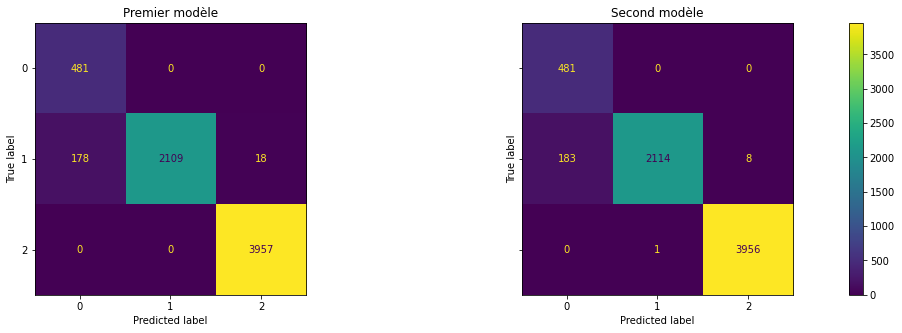

In [126]:
f, axes = plt.subplots(1, 2, figsize=(20, 5), sharey='row')

disp1 = ConfusionMatrixDisplay(matrix1)
disp1.plot(ax=axes[0])
disp1.ax_.set_title("Premier modèle")
disp1.im_.colorbar.remove()

disp2 = ConfusionMatrixDisplay(matrix2)
disp2.plot(ax=axes[1])
disp2.ax_.set_title("Second modèle")
disp2.im_.colorbar.remove()

plt.subplots_adjust()


f.colorbar(disp2.im_, ax=axes)
plt.show()

On remarque avec les matrices de confusion que le second modèle a de meilleures performances, notamment sur la prédiction de la première classe. Cette amélioration est certainement due aux 16 filtres supplémentaires dont dispose ce modèle ce qui accroit encore ses performances. Néanmoins, ces filtres supplémentaires augmentent relativement le nombre de paramètres (il est presque doublé pour le deuxième modèle mais ce nombre reste tout à fait raisonnable).

On constate également que les erreurs ont lieux aux intersections entre 2 classes. Par exemple pour le second modèle, quand il prédit la classe 2, il fait uniquement des erreurs avec la classe 1 qui est la classe de transition survenant juste avant la classe 2 représentant le problème dans les tuyaux. On peut donc en déduire que l'aspect temporel est "compris" par le réseaux (tel évenement survient avant ou après tel autre). 